PREPARING VECTOR DATA (SHAPEFILES) FOR MERGING

In [28]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

In [29]:
# Read vector data
road_bounds = gpd.read_file('dataset_ex_2/grid-111/dop20rgb_386_5826_2022_bounds_grid-111.shp')
buildings = gpd.read_file('dataset_ex_2/grid-111/dop20rgb_386_5826_2022_buildings_grid-111.shp')
road_markings = gpd.read_file('dataset_ex_2/grid-111/dop20rgb_386_5826_2022_markings_grid-111.shp')

# Print the CRS of each shapefile
print("CRS of road_bounds:", road_bounds.crs)
print("CRS of buildibgs:", buildings.crs)
print("CRS of road_markings:", road_markings.crs)

CRS of road_bounds: EPSG:4326
CRS of buildibgs: EPSG:25833
CRS of road_markings: EPSG:25833


We notice the CRS doesnt match for all shapefiles therefore we must transform all to a common CRS before the union/merging 

In [30]:
# Define the common CRS (WGS 84)
common_crs = "EPSG:25833"

# Transform the shapefiles to the common CRS
road_bounds = road_bounds.to_crs(common_crs)
buildings = buildings.to_crs(common_crs)
road_markings = road_markings.to_crs(common_crs)

print ("common CRS set")

common CRS set


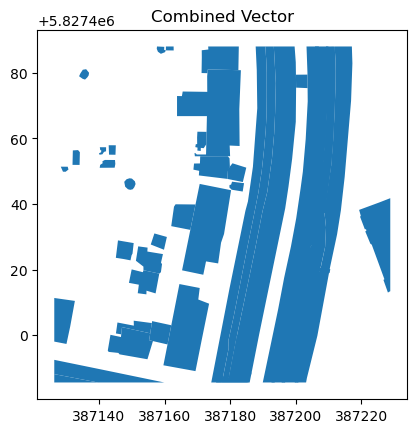

In [31]:

# Combine the shapefiles
combined_shapefile = gpd.GeoDataFrame(pd.concat([road_bounds, buildings, road_markings], ignore_index=True))

# Plot the combined shapefile
combined_shapefile.plot()
plt.title('Combined Vector')
plt.show()

In [32]:

# Save the combined shapefile
combined_shapefile.to_file('dataset_ex_2/grid-111/combined')
print (f"File saved successfully")


File saved successfully


PROCESS TO RASTERIZE

In [33]:
import geopandas as gpd
import numpy as np

import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds

import matplotlib.pyplot as plt

In [34]:
# Load the merged vector shapefile
input_shapefile = 'dataset_ex_2/grid-111/combined/combined.shp'
gdf = gpd.read_file(input_shapefile)
print(f"File loaded successfully: {input_shapefile}")


File loaded successfully: dataset_ex_2/grid-111/combined/combined.shp


In [35]:

# Assuming the vector data has 'attributes' that corresponds to the features
# Assign pixel values based on the feature type
pixel_values = {
    'road_bounds': [0, 0, 200],
    'building': [255, 0, 0],
    'broken_line': [0, 20, 10],
    'cycle_lane': [0, 40, 0],
    'dashed_line': [0, 45, 70],
    'pedestrian_crossing': [0, 100, 0],
    'solid_line': [0, 45, 0],
    'stop_line': [0, 85, 0]
}


# Map feature types(attributes) to pixel values
# Create a new column 'pixel_value' based on the feature type
gdf['pixel_value'] = gdf['attributes'].map(pixel_values)

#too see the geodataframe or attribute table as known in GIS sodtware
print(gdf)


    id      attributes  Comments  comments_1  \
0    1       motorized       NaN         NaN   
1    2      cycle_lane       NaN         NaN   
2    3       motorized       NaN         NaN   
3    4      cycle_lane       NaN         NaN   
4    7  traffic_island       NaN         NaN   
..  ..             ...       ...         ...   
76  86      solid_line       NaN         NaN   
77  88      solid_line       NaN         NaN   
78  89      cycle_lane       NaN         NaN   
79  90     dashed_line       NaN         NaN   
80  91     dashed_line       NaN         NaN   

                                             geometry  pixel_value  
0   POLYGON ((387189.945 5827385.600, 387194.621 5...          NaN  
1   POLYGON ((387196.310 5827385.600, 387198.445 5...   [0, 40, 0]  
2   POLYGON ((387179.319 5827385.600, 387181.879 5...          NaN  
3   POLYGON ((387177.301 5827385.600, 387177.831 5...   [0, 40, 0]  
4   POLYGON ((387185.948 5827385.600, 387185.950 5...          NaN  
..       

NaN Values of pixels  cause "ValueError: cannot convert float NaN to integer" in the rasterization when its converting the pixel values to integers, therefore

In [36]:
# Filter out rows with NaN values in 'pixel_values' column
filtered_gdf = gdf.dropna(subset=['pixel_value'])

# Remove the 'Comments' and 'comments_1' columns, they're unnecesary for rasterization
filtered_gdf = filtered_gdf.drop(columns=['Comments', 'comments_1'])
# Display the new dataframe
print(filtered_gdf)

    id           attributes  \
1    2           cycle_lane   
3    4           cycle_lane   
36   1            stop_line   
37   5            stop_line   
38  24          broken_line   
39  25          broken_line   
40  26          broken_line   
41  27          broken_line   
42  28          broken_line   
43  29          broken_line   
44  30          broken_line   
45  31          broken_line   
46  32          broken_line   
47  33          broken_line   
48  34          broken_line   
49  35          broken_line   
50  36          broken_line   
51  37          broken_line   
52  38          broken_line   
53  39          broken_line   
54  40          broken_line   
55  60          broken_line   
56  61          broken_line   
57  62          broken_line   
58  63          broken_line   
59  64          broken_line   
60  65          broken_line   
61  66          broken_line   
62  67          broken_line   
63  68          broken_line   
64  69          broken_line   
65  70  

In [37]:

# Define the output raster properties
out_raster = 'dataset_ex_2/raster_rgb_mask.tif'
pixel_size = 1.0  # Adjust as necessary
xmin, ymin, xmax, ymax = filtered_gdf.total_bounds
width = int((xmax - xmin) / pixel_size)
height = int((ymax - ymin) / pixel_size)
transform = from_bounds(xmin, ymin, xmax, ymax, width, height)

# Create an empty array to store the rasterized image
image = np.zeros((height, width, 3), dtype=np.uint8)

# Rasterize each feature based on its pixel value
for idx, row in filtered_gdf.iterrows():
    geom = row.geometry
    value = row.pixel_value
    mask = rasterize([(geom, 1)], out_shape=(height, width), transform=transform)
    image[mask > 0] = value

# Transpose the image array to match the expected shape (bands, height, width)
image = image.transpose((2, 0, 1))

# Save the raster to a GeoTIFF file
with rasterio.open(out_raster, 'w', driver='GTiff', width=width, height=height, count=3, dtype=np.uint8, crs=filtered_gdf.crs, transform=transform) as dst:
    dst.write(image)

print(f"mask raster saved successfully: {out_raster}")   

mask raster saved successfully: dataset_ex_2/raster_rgb_mask.tif


In [38]:
print(f"mask raster saved successfully: {out_raster}")

mask raster saved successfully: dataset_ex_2/raster_rgb_mask.tif


By using image.transpose((1, 2, 0)), we are changing the order of dimensions from (bands, height, width) to (height, width, bands), which is suitable for displaying with plt.imshow.

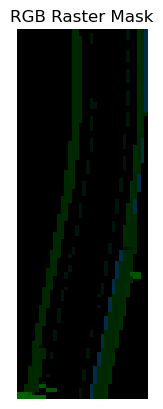

In [39]:
# Transpose the image array back to (height, width, channels) for plotting
image_plot = image.transpose((1, 2, 0))

# Plot the raster image
plt.title('RGB Raster Mask')
plt.imshow(image_plot)
plt.axis('off')
plt.show()